In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os
from tqdm import tqdm

In [2]:
# ignore warning 
import warnings
warnings.filterwarnings("ignore")

In [2]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(data_dir, label)
        class_num = 1 if label == 'PNEUMONIA' else 0
        for img in tqdm(os.listdir(path)[:1000]):
            try:
                if not img.endswith('.DS_Store'): # Skip non-image files
                    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (150, 150)) # Resize image to (150, 150)
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {os.path.join(path, img)}: {str(e)}")
    return np.array(data, dtype=object) # Specify dtype as object



In [3]:
train = get_training_data('chest_xray/chest_xray/train')
test = get_training_data('chest_xray/chest_xray/test')
val = get_training_data('chest_xray/chest_xray/val')

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 262.36it/s]


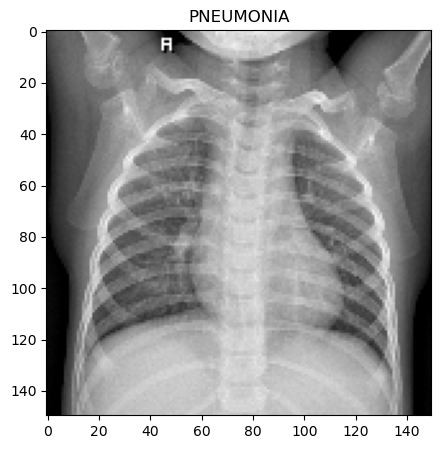

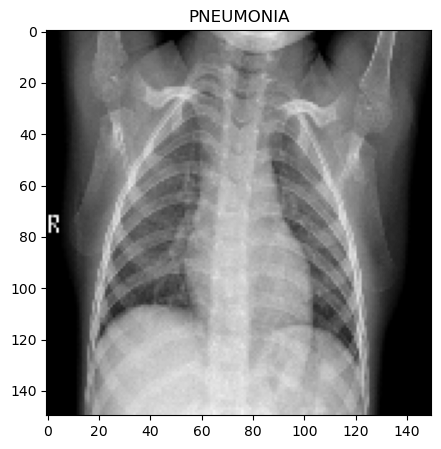

In [4]:
# Pneumonia Sample
plt.figure(figsize = (5,5))
plt.imshow(train[2][0], cmap='gray')
plt.title(labels[train[2][1]])

# Normal Sample
plt.figure(figsize = (5,5))
plt.imshow(train[322][0], cmap='gray')
plt.title(labels[train[322][1]])
plt.show()

In [5]:
# Train
x_train = []
y_train = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)


# Validaiton 
x_val = []
y_val = []
   
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)


# Test 
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

 

In [6]:
# Normalize the data
x_train = (np.array(x_train) / 255)
x_val = (np.array(x_val) / 255)
x_test = (np.array(x_test) / 255)

In [7]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size , 1 )

In [8]:
x_train.shape

(1999, 150, 150, 1)

### Imbalanced Data with smote 

In [9]:
# resize images for smote 
x_train = x_train.reshape(1999,150*150*1)

In [10]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=2)
X_smote, y_smote = sm.fit_resample(x_train, y_train)

In [11]:
X_smote = X_smote.reshape(-1, img_size, img_size, 1)

In [12]:
from tensorflow import keras 
class MCDropout(keras.layers.Dropout):
    def call(self , inputs):
        return super().call(inputs , training = True )

2024-07-24 03:18:46.244797: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 03:18:46.399756: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 03:18:46.560958: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 03:18:46.710550: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 03:18:46.748503: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 03:18:48.891708: W tensorflow/compiler/tf2tensorrt/utils/p

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten 
from tensorflow.keras import regularizers , constraints 


In [14]:

def SimpleModel(units=32, dropout_rate=0.5):
    simpleModel = Sequential()
    simpleModel.add(Conv2D(units , kernel_size = (3,3),  strides = 1  , padding = 'same' , activation = 'linear' , input_shape = (150,150,1)))
    simpleModel.add(MaxPool2D((2,2)))


    simpleModel.add(Conv2D(units , (3,3), activation = 'relu' , kernel_regularizer = regularizers.l2(l2 = 0.01)))
    simpleModel.add(MaxPool2D(pool_size = (2,2)))
    simpleModel.add(MCDropout(dropout_rate))
    
    
    simpleModel.add(Flatten())
    simpleModel.add(Dense(units = 256 , activation = 'relu' , kernel_initializer = "glorot_uniform" , kernel_regularizer = regularizers.l2(l2 = 0.01)))
    simpleModel.add(MCDropout(dropout_rate))

    simpleModel.add(Dense(1 ,  activation = 'sigmoid' , kernel_initializer = "glorot_uniform" )) 
    simpleModel.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    
    return simpleModel

In [73]:
from tensorflow.keras import optimizers , losses 
from tensorflow.keras.callbacks import EarlyStopping 
simpleModel = SimpleModel()
early_stopping = EarlyStopping()

simpleModel.compile(
    loss = "binary_crossentropy",
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics =['accuracy']
) 
history = simpleModel.fit(X_smote, y_smote , epochs = 5 , batch_size = 32, validation_data = (x_val , y_val), shuffle=True )

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 37s 554ms/step - accuracy: 0.5954 - loss: 4.9312 - val_accuracy: 0.6250 - val_loss: 2.6564
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 559ms/step - accuracy: 0.8017 - loss: 2.1366 - val_accuracy: 0.6875 - val_loss: 2.0098
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 538ms/step - accuracy: 0.8833 - loss: 1.3855 - val_accuracy: 0.6250 - val_loss: 1.5450
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 42s 554ms/step - accuracy: 0.9097 - loss: 1.0939 - val_accuracy: 0.9375 - val_loss: 1.0184
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 556ms/step - accuracy: 0.9074 - loss: 0.9914 - val_accuracy: 0.8750 - val_loss: 0.9346


### evaluate the model 

In [74]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt 

In [76]:
y_pred = simpleModel.predict(x_test)
cr = classification_report(y_test,np.round(y_pred))
print(cr)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step
              precision    recall  f1-score   support

           0       0.85      0.71      0.78       234
           1       0.84      0.93      0.88       390

    accuracy                           0.85       624
   macro avg       0.85      0.82      0.83       624
weighted avg       0.85      0.85      0.84       624



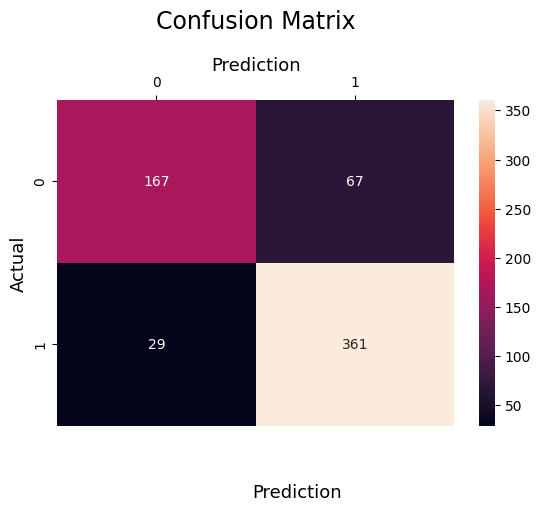

In [77]:
cm = confusion_matrix(y_test,np.round(y_pred))

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['0','1'], yticklabels=['0','1']) 
plt.ylabel('Actual', fontsize=13) 
plt.title('Confusion Matrix', fontsize=17, pad=20) 
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13) 
plt.gca().xaxis.tick_top() 
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()


* we used less train data its about 2k rows and we got a nice accuracy 

### using diffrent model 

In [26]:
from keras.layers import BatchNormalization , Dropout 
from keras.callbacks import ReduceLROnPlateau

def SecondModel():    
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'linear' , input_shape = (150,150,1)))
    # model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    # model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    # model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
    
    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    model.summary()

    return model 


* if u uncomments the Batchnormalization layers u will got 0.v on val accuracy maybe cause u use high batch size

In [27]:
secondModel = SecondModel()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,244,225 (4.75 MB)

 Trainable params: 1,244,225 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)


In [28]:

history = secondModel.fit(X_smote,y_smote, batch_size = 32 ,epochs = 5 , validation_data = (x_val, y_val) ,callbacks = [learning_rate_reduction])


Epoch 1/5


2024-07-24 03:41:19.398380: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 180000000 exceeds 10% of free system memory.


63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.6284 - loss: 0.6261 - val_accuracy: 0.7500 - val_loss: 0.4498
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.9113 - loss: 0.2326 - val_accuracy: 0.9375 - val_loss: 0.2422
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.9567 - loss: 0.1338 - val_accuracy: 0.9375 - val_loss: 0.2436
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9530 - loss: 0.1162 - val_accuracy: 0.8125 - val_loss: 0.3660
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9333 - loss: 0.1651 - val_accuracy: 0.9375 - val_loss: 0.2005


### evaluate the model 

In [31]:
y_pred = secondModel.predict(x_test)
cr = classification_report(y_test,np.round(y_pred))
print(cr)

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 582ms/step
              precision    recall  f1-score   support

           0       0.96      0.49      0.65       234
           1       0.76      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.75       624
weighted avg       0.84      0.80      0.78       624



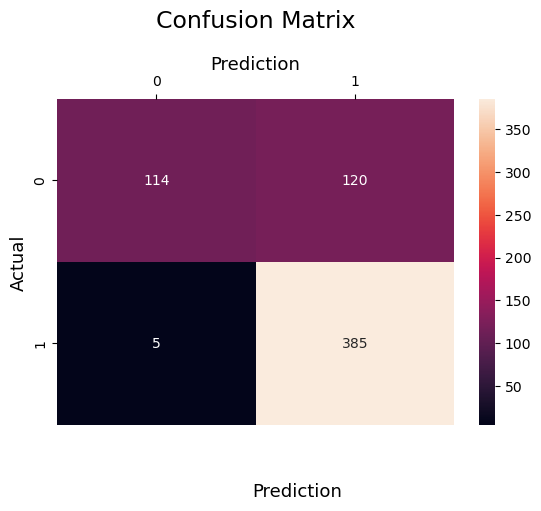

In [32]:
cm = confusion_matrix(y_test,np.round(y_pred))

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['0','1'], yticklabels=['0','1']) 
plt.ylabel('Actual', fontsize=13) 
plt.title('Confusion Matrix', fontsize=17, pad=20) 
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13) 
plt.gca().xaxis.tick_top() 
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()


### using Randmoized Search CV

In [20]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

2024-07-24 02:34:12.790450: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 02:34:12.942312: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 02:34:13.099044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-24 02:34:13.231569: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-24 02:34:13.265652: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-24 02:34:15.885376: W tensorflow/compiler/tf2tensorrt/utils/p

In [30]:
# it take a long time so maybe we will try it later 
param_grid = {
    'units': [16, 32, 64],
    'dropout_rate': [0.1, 0.5],
}


model = KerasClassifier(build_fn=SimpleModel,
                            units=32, 
                            dropout_rate=0.5,
                            epochs=5,
                            batch_size=32,
                            verbose=0)


RS = RandomizedSearchCV(estimator= model, 
                                       param_distributions=param_grid,
                                       cv=3)

best_parameters = RS.fit(X_smote, y_smote )

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f2ea5877490>
Traceback (most recent call last):
  File "/usr/lib/python3.10/weakref.py", line 370, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt: 

KeyboardInterrupt



In [ ]:
best = best_parameters.best_params_

In [ ]:
pd.DataFrame(best_parameters.cv_results_)[["params"]]

In [ ]:
from keras.applications import VGG16